In [1]:
import rasterio
from rasterio import plot
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
import math
import seaborn as sns
from typing import List, Dict
from zipfile import ZipFile

from ml_commons import *

sns.set_theme()

Set prerequisites for image labeling

In [2]:
dataset_dir = os.path.join('data', 'queries', 'Montana')
features_dir = os.path.join(dataset_dir, 'features')
preprocessing_dir = os.path.join(dataset_dir, 'preprocessing')
labels_path = os.path.join(preprocessing_dir, f'labels.csv')

In [3]:
cloud_cover_order = ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']

Extract all zip files of the features subdirectory

In [4]:
products = os.listdir(features_dir)
for file in tqdm(list(filter(lambda x: x.endswith('.zip'), products))):
    filepath = os.path.join(features_dir, file)
    with ZipFile(filepath) as zip_file:
        zip_file.extractall(features_dir)
    os.remove(filepath)
products = os.listdir(features_dir)

0it [00:00, ?it/s]

First run data-mining notebook!
Then update labels to contain true cloud cover (manual labels for the satellite images).

In [5]:
if os.path.exists(labels_path):
    labels = pd.read_csv(labels_path, index_col=0)
else:
    raise RuntimeError('Run data-mining notebook first!')
if 'true cloud cover' not in labels.columns:
    labels['true cloud cover'] = None
labels.to_csv(labels_path)
labels

,station,product_id,timedelta [minutes],max cloud cover,true cloud cover
0,LWT,0080c409-b51d-43e6-a05e-7976bd3a6200,-12.317083,OVC,OVC
1,1KM,009c2bae-52a1-4c5a-9db8-08458c05b247,-14.183733,CLR,SCT
2,BIL,0165b811-52b7-49b2-ab53-e4ce0ebd57db,-24.517067,FEW,CLR
3,BHK,01ed7eec-964a-4869-a976-83c83483f6d5,-1.150417,OVC,OVC
4,LWT,01ef70dd-5201-4c7e-9f21-2f56384e1a4c,16.682933,OVC,BKN
...,...,...,...,...,...
915,LVM,fe360358-f57f-4b6e-9db9-c079deb4ceca,-26.350400,CLR,FEW
916,S85,fed7ec5b-8e5b-4a2d-9df9-aef0d16dd1b5,3.849600,FEW,FEW
917,6S0,ff47c6df-6de0-4ff7-83e2-697d6fe4669c,-4.317067,BKN,OVC
918,LVM,ff47c6df-6de0-4ff7-83e2-697d6fe4669c,-2.317067,OVC,OVC


Find image index from which to continue and run labeling program

In [17]:
image_index = labels[labels['true cloud cover'].isin(cloud_cover_order)].last_valid_index()
if image_index is None:
    image_index = 0
else:
    image_index += 1
print(f'Starting at index {image_index}')

Starting at index 901


In [7]:
button_colors = sns.color_palette(sns.color_palette('Blues', len(cloud_cover_order)))
bg_lightness = [np.mean(color) for color in button_colors]
button_text_colors = ['#0e2532' if x > 0.5 else '#ffffff' for x in bg_lightness]
button_colors = button_colors.as_hex()
print(button_colors)
print(button_text_colors)
button_colors = list(zip(button_text_colors, button_colors))

['#d6e6f4', '#abd0e6', '#6aaed6', '#3787c0', '#105ba4']
['#0e2532', '#0e2532', '#0e2532', '#ffffff', '#ffffff']


In [8]:
def load_image(path:str) -> torch.Tensor:
    image: rasterio.DatasetReader = rasterio.open(path)
    image_tensor = torch.from_numpy(image.read(1).astype(np.float32))
    image.close()
    return image_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Wanted another image..
Took 1.152 seconds
Used concurrent image retrieval - NICE!
Took 0.709 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Used concurrent image retrieval - NICE!
Took 0.741 seconds
Used concurrent image retrieval - NICE!
Took 0.702 seconds
Used concurrent image retrieval - NICE!
Took 0.699 seconds
Used concurrent image retrieval - NICE!
Took 0.711 seconds
Used concurrent image retrieval - NICE!
Took 0.710 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Used concurrent image retrieval - NICE!
Took 0.753 seconds
Used concurrent image retrieval - NICE!
Took 0.702 seconds
Used concurrent image retrieval - NICE!
Took 0.699 seconds
Used concurrent image retrieval - NICE!
Took 0.716 seconds
Used concurrent image retrieval - NICE!
Took 0.704 seconds
Used concurrent image retrieval - NICE!
Took 0.708 seconds
Used concurrent image retrieval - NICE!
Took 0.710 seconds
Used concurrent image retrieval - NICE!
Took 0.724 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Used concurrent image retrieval - NICE!
Took 0.770 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Used concurrent image retrieval - NICE!
Took 0.757 seconds
Used concurrent image retrieval - NICE!
Took 0.713 seconds
Used concurrent image retrieval - NICE!
Took 0.710 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Used concurrent image retrieval - NICE!
Took 0.768 seconds


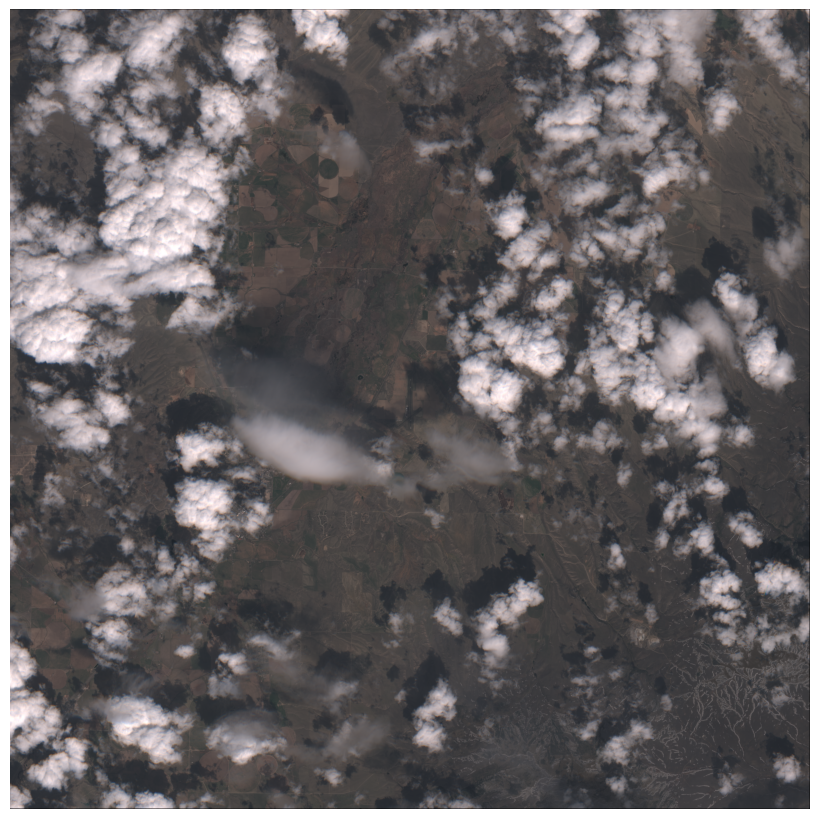

In [19]:
import gc
import PySimpleGUI as sg
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import torch
from torchvision import transforms
from concurrent import futures

def get_window_title() -> str:
    return f'{image_index + 1} / {labels.shape[0]} [{float(image_index + 1) / float(labels.shape[0]) * 100.0:.1f} %]'

def get_image(index) -> Tuple[torch.Tensor, int]:
    def get_image_path(row, band:str):
        return os.path.join(features_dir, row['product_id'], band, row['station'] + '.jp2')
    def fuse_images(image_paths:Dict[str, str]):
        images = {band: load_image(path) / 10000 for band, path in image_paths.items()}
        images['B11'] = torchvision.transforms.Resize(images['B2'].shape, torchvision.transforms.InterpolationMode.BICUBIC)(images['B11'].unsqueeze(0)).squeeze(0)
        index: torch.Tensor = (images['B3'] - images['B11']) / (images['B3'] + images['B11'])
        index = index
        index = index.clip(0.0, 1.0)
        # return torch.stack([images['B4'], images['B3'], images['B2']])                # = RGB
        # return torch.stack([index, index, index])                                     # = NDSI
        return torch.stack([images['B4'], images['B3'], images['B2']]) * (1.0 - index)  # = RGB * (1 - NDSI)
    row = labels.iloc[index]
    img_paths = {band: get_image_path(row, band) for band in ['B2', 'B3', 'B4', 'B11']}
    if not all([os.path.exists(path) for path in img_paths.values()]):
        raise RuntimeError('Unable to find all paths' + img_paths.values())
    image_tensor = fuse_images(img_paths)
    return image_tensor, index

def plot_image(image_tensor:torch.Tensor):
    fig, ax = plt.subplots(figsize=(8, 8))
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    ax.imshow(image_tensor.permute(1, 2, 0))
    return fig, ax

def draw_image(canvas, figure):
    agg = FigureCanvasTkAgg(figure, canvas)
    agg.draw()
    agg.get_tk_widget().pack(side='top', fill='both', expand=True)
    return agg

image_future = None
image, actual_image_index = get_image(image_index)
fig, ax = plot_image(image)
figure_x, figure_y, figure_w, figure_h = fig.bbox.bounds

layout = [[sg.Canvas(size=(figure_w, figure_h), key='canvas')],
          [sg.Button(cc, button_color=button_colors[i]) for i, cc in enumerate(cloud_cover_order)] +
          [sg.Button('<--', button_color=sns.color_palette('Reds', 2).as_hex())]]

font = ('Inter', 16)
window = sg.Window(get_window_title(), layout, element_justification='c', font=font, finalize=True)

agg = draw_image(window['canvas'].TKCanvas, fig)
gc.collect()
while True:
    event, values = window.read()
    # End program if user closes window
    if event == sg.WIN_CLOSED:
        agg.get_tk_widget().forget()
        plt.close('all')
        labels.to_csv(labels_path)
        break
    if event in cloud_cover_order or event == '<--':
        if event in cloud_cover_order:
            labels.at[image_index, 'true cloud cover'] = event
        if event == '<--':
            image_index -= 1
        else:
            image_index += 1
        if image_index < labels.shape[0]:
            time_start = time.perf_counter()
            agg.get_tk_widget().forget()
            plt.close('all')
            ax.cla()
            if image_index != actual_image_index or image_future is None:
                image, actual_image_index = get_image(image_index)
                print('Wanted another image..')
            else:
                image, actual_image_index = image_future.result()
                print('Used concurrent image retrieval - NICE!')
            fig, ax = plot_image(image)
            window.set_title(get_window_title())
            agg = draw_image(window['canvas'].TKCanvas, fig)
            gc.collect()
            window.refresh()
            time_end = time.perf_counter()
            print(f'Took {time_end - time_start:.3f} seconds')
            if image_index + 1 < labels.shape[0]:
                actual_image_index = image_index + 1
                executor = futures.ThreadPoolExecutor(max_workers=1)
                image_future = executor.submit(get_image, actual_image_index)
        else:
            break
        labels.to_csv(labels_path)

labels.to_csv(labels_path)
gc.collect()
window.close()

Perform analysis on manually labeled data

In [505]:
labels_to_analyze = labels[~labels['true cloud cover'].isna()].copy()
labels_to_analyze

,station,product_id,timedelta [minutes],max cloud cover,true cloud cover
0,E38,00007283-0b01-4764-a8b2-e2379f37028f,1.816267,CLR,BKN
1,TPL,0005d67b-d282-4a1d-9e9f-cd6585241657,-12.483733,CLR,BKN
2,GDP,00096b08-8b91-411a-8195-734996580ca2,14.149600,CLR,SCT
3,F00,0054147d-0b99-4f1e-a122-ee5f3f8dd67e,-3.850400,CLR,CLR
4,CXO,0062a150-5d82-4ad7-af59-f406bbd7f8c0,-5.817067,CLR,CLR
...,...,...,...,...,...
4843,GNC,ffd5bab3-4250-44ef-837f-04e213a66586,-2.017067,CLR,FEW
4844,LUV,ffd5bab3-4250-44ef-837f-04e213a66586,2.982933,CLR,FEW
4845,ORG,ffd7c508-0a7d-4185-9ce8-511fc421d012,4.149600,SCT,BKN
4846,11R,fff52610-ce95-4c6b-9ebc-5d6912f0ff3d,8.316267,OVC,BKN


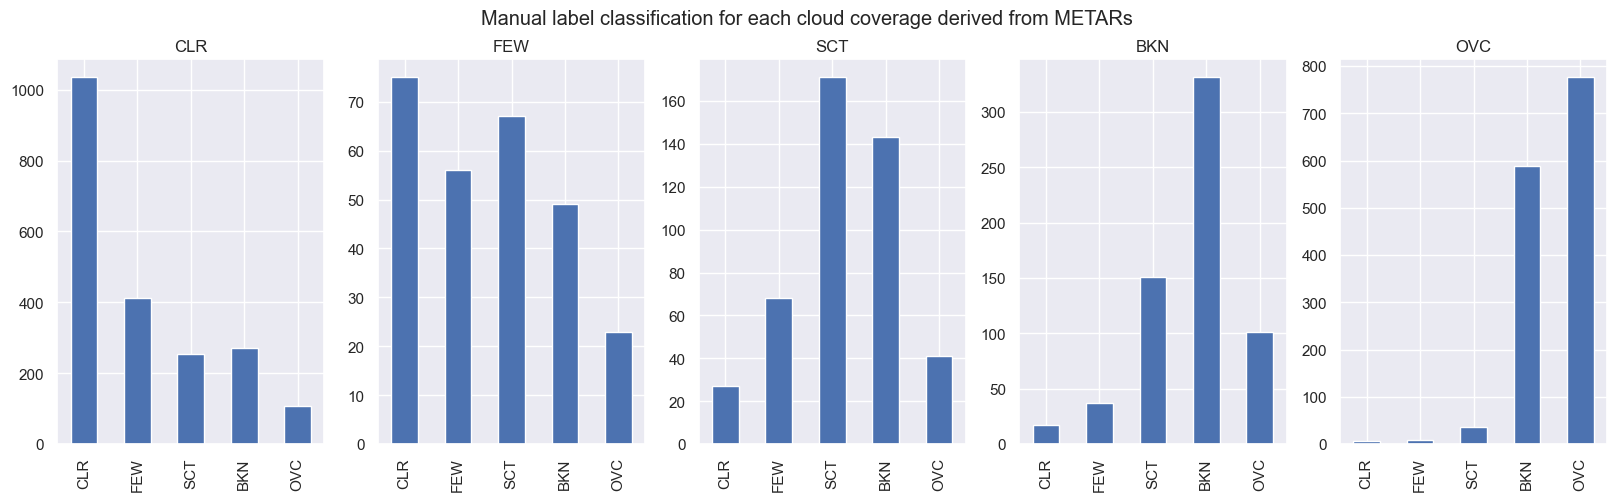

In [506]:
from collections import Counter

cc_counts = {}
fig, axs = plt.subplots(figsize=(4 * len(cloud_cover_order), 5), ncols=len(cloud_cover_order))
fig.suptitle('Manual label classification for each cloud coverage derived from METARs')
for i, cc in enumerate(cloud_cover_order):
    ax: plt.Axes = axs[i]
    counted_labels = pd.Series(Counter(labels_to_analyze[labels_to_analyze['max cloud cover'] == cc]['true cloud cover']))
    for cc_ in cloud_cover_order:
        if cc_ not in counted_labels:
            counted_labels[cc_] = 0
    counted_labels = counted_labels.loc[cloud_cover_order]
    counted_labels.plot.bar(ax=ax, title=cc)
    cc_counts[cc] = counted_labels

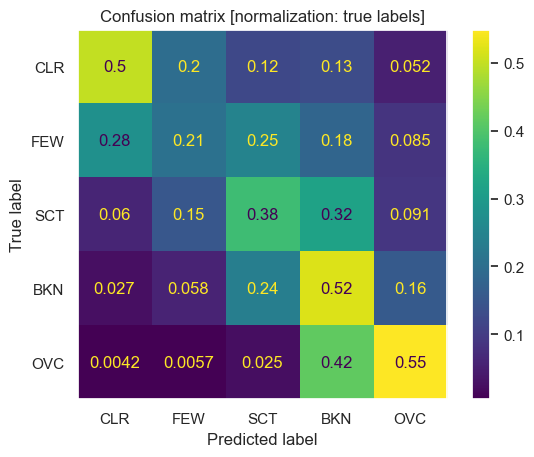

In [507]:
# compute the confusion matrix
from enum import Enum
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


class_names =   ['CLR', 'FEW', 'SCT', 'BKN', 'OVC']
classes = list(range(len(class_names)))
class_dict = {name: i for i, name in enumerate(class_names)}

class ConfusionMatrixNormalization(str, Enum):
    ALL_SAMPLES = 'all',
    TRUE_LABELS = 'true',
    PREDICTED_LABELS = 'pred'

normalization = ConfusionMatrixNormalization.TRUE_LABELS
normalization_mode = None
title = 'Confusion matrix'
if normalization is not None:
    normalization_mode = normalization.value
    title += ' [normalization: ' + normalization.name.lower().replace('_', ' ') + ']'
# set the model to evaluation mode

cm = confusion_matrix(y_true=labels_to_analyze['max cloud cover'].apply(lambda x: class_dict[x]),
                      y_pred=labels_to_analyze['true cloud cover'].apply(lambda x: class_dict[x]),
                      labels=range(len(cloud_cover_order)), normalize=normalization_mode)

# display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cloud_cover_order)
disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal')
plt.grid(False)
plt.title(title)
plt.show()

cm = pd.DataFrame(cm, columns=cloud_cover_order, index=cloud_cover_order)

In [508]:
cm

,CLR,FEW,SCT,BKN,OVC
CLR,0.498315,0.198363,0.121810,0.129995,0.051517
FEW,0.277778,0.207407,0.248148,0.181481,0.085185
SCT,0.060000,0.151111,0.380000,0.317778,0.091111
BKN,0.026688,0.058085,0.237049,0.519623,0.158556
OVC,0.004243,0.005658,0.025460,0.415842,0.548798


In [509]:
def direct_neighbor_accumulation(data:pd.DataFrame) -> pd.DataFrame:
    result = []
    for i, cc in enumerate(cloud_cover_order):
        local_result = {'cloud cover': cc}
        cc_sum = data.loc[cc, cc]
        if i > 0:
            cc_sum += data.loc[cc, cloud_cover_order[i - 1]]
        if i < len(cloud_cover_order) - 1:
            cc_sum += data.loc[cc, cloud_cover_order[i + 1]]
        local_result['value'] = cc_sum
        result += [local_result]
    result = pd.DataFrame(result)
    result.set_index('cloud cover', inplace=True)
    return result

cc_neighbor_acc = direct_neighbor_accumulation(cm)
cc_neighbor_acc

,value
cloud cover,
CLR,0.696678
FEW,0.733333
SCT,0.848889
BKN,0.915228
OVC,0.964639


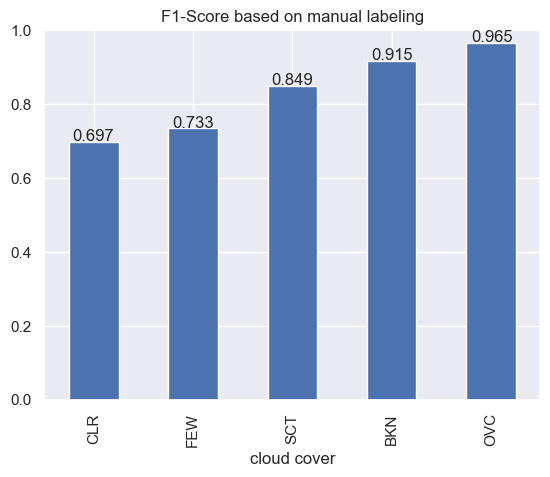

In [510]:
ax = cc_neighbor_acc.plot.bar(legend=False, title='F1-Score based on manual labeling')
ax.set_ylim(0, 1)
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', (p.get_x() * 1.005 + 0.03, p.get_height() * 1.005))

In [511]:
mislabeled = labels_to_analyze['max cloud cover'] != labels_to_analyze['true cloud cover']

In [512]:
labels_to_analyze['mismatch intensity'] = labels_to_analyze.apply(lambda row: class_dict[row['max cloud cover']] - class_dict[row['true cloud cover']], axis='columns')
labels_to_analyze['mismatch intensity']

0      -3
1      -3
2      -2
3       0
4       0
       ..
4843   -1
4844   -1
4845   -1
4846    1
4847    1
Name: mismatch intensity, Length: 4848, dtype: int64

array([[<Axes: title={'center': 'BKN'}, xlabel='mismatch intensity'>,
        <Axes: title={'center': 'CLR'}, xlabel='mismatch intensity'>,
        <Axes: title={'center': 'FEW'}, xlabel='mismatch intensity'>,
        <Axes: title={'center': 'OVC'}, xlabel='mismatch intensity'>,
        <Axes: title={'center': 'SCT'}, xlabel='mismatch intensity'>]],
      dtype=object)

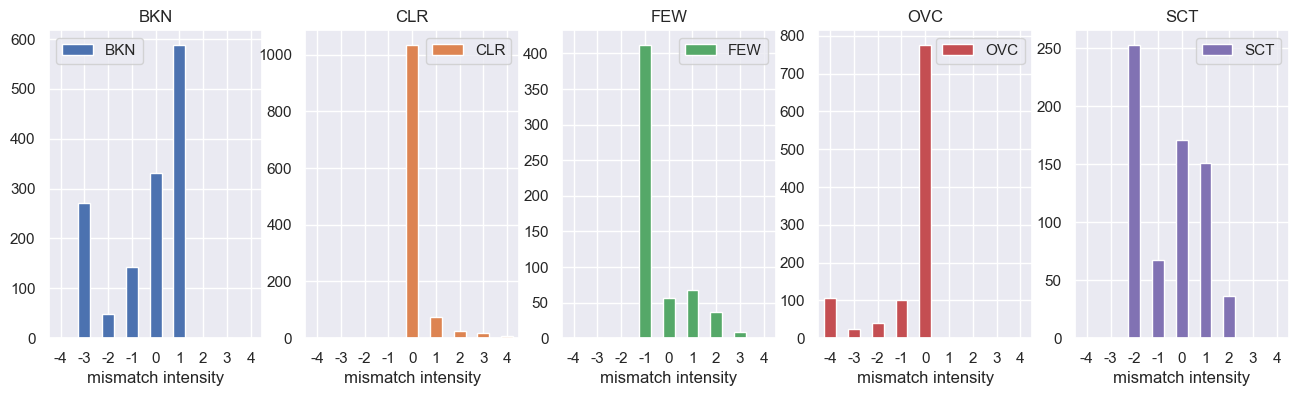

In [513]:
labels_to_analyze.groupby(['true cloud cover', 'mismatch intensity'])['max cloud cover'].count().loc[cloud_cover_order].unstack(level=0).plot(kind='bar', subplots=True, rot=0, figsize=(16, 4), layout=(1, 5))

In [514]:
labels_to_analyze[mislabeled].groupby('max cloud cover')['true cloud cover'].count().loc[cloud_cover_order]

max cloud cover
CLR    1042
FEW     214
SCT     279
BKN     306
OVC     638
Name: true cloud cover, dtype: int64

<Axes: title={'center': 'Frequency of mislabeling based on METAR labels'}, xlabel='max cloud cover'>

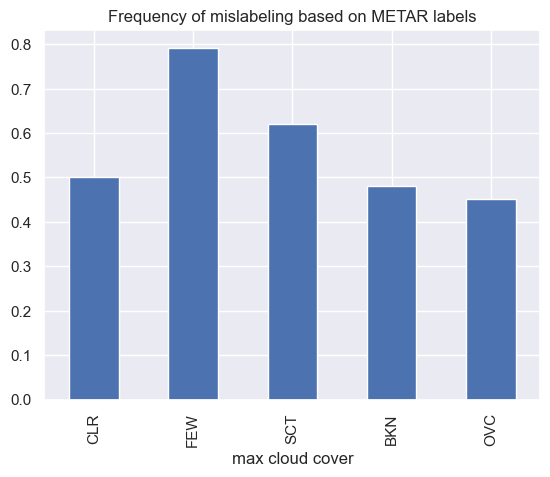

In [515]:
(labels_to_analyze[mislabeled].groupby('max cloud cover')['true cloud cover'].count().loc[cloud_cover_order] / labels_to_analyze.groupby('max cloud cover')['true cloud cover'].count().loc[cloud_cover_order]).plot.bar(title='Frequency of mislabeling based on METAR labels')

In [516]:
hard_mislabeled = labels_to_analyze['mismatch intensity'].abs() > 1

Text(0.5, 1.0, 'Time difference between satellite image and METAR observation')

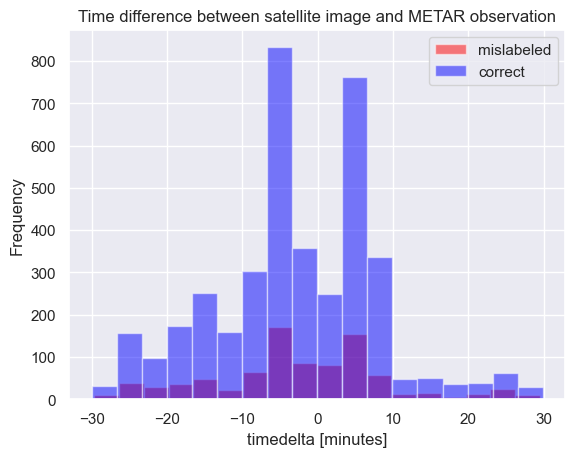

In [517]:
fig, ax = plt.subplots()
plot_bins = 18
labels_to_analyze[hard_mislabeled]['timedelta [minutes]'].plot.hist(bins=plot_bins, ax=ax, alpha=0.5, color='red', label='mislabeled')
labels_to_analyze[~hard_mislabeled]['timedelta [minutes]'].plot.hist(bins=plot_bins, ax=ax, alpha=0.5, color='blue', label='correct')
ax.set_xlabel('timedelta [minutes]')
ax.legend()
ax.set_title('Time difference between satellite image and METAR observation')

Text(0.5, 1.0, 'Time Differences of Correct Data')

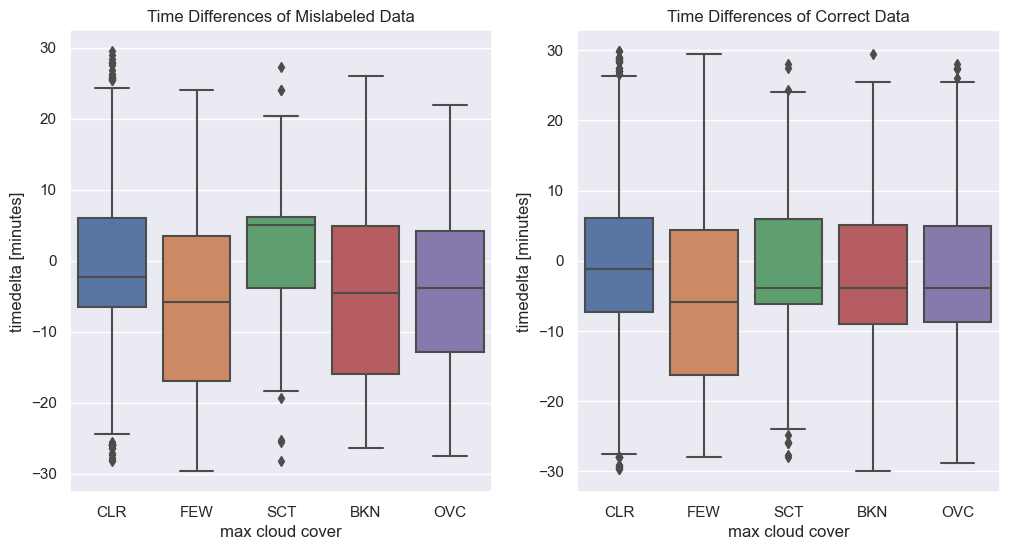

In [518]:
fig, axs = plt.subplots(figsize=(12,6), ncols=2)
sns.boxplot(labels_to_analyze[hard_mislabeled], x='max cloud cover', y='timedelta [minutes]', order=cloud_cover_order, ax=axs[0])
axs[0].set_title('Time Differences of Mislabeled Data')
sns.boxplot(labels_to_analyze[~hard_mislabeled], x='max cloud cover', y='timedelta [minutes]', order=cloud_cover_order, ax=axs[1])
axs[1].set_title('Time Differences of Correct Data')

In [519]:
mislabels_by_station = labels_to_analyze[hard_mislabeled].groupby('station')['max cloud cover'].count()
labels_by_station = labels_to_analyze.groupby('station')['max cloud cover'].count()

In [520]:
mislabels_by_station_rel = []
for i, count in mislabels_by_station.items():
    mislabels_by_station_rel += [{'station': i, 'frequency': count / labels_by_station.loc[i]}]
mislabels_by_station_rel = pd.DataFrame(mislabels_by_station_rel)
mislabels_by_station_rel.set_index('station', inplace=True)
mislabels_by_station_rel.sort_values('frequency', inplace=True)
mislabels_by_station_rel

,frequency
station,
RND,0.027027
CRP,0.029412
NQI,0.029412
66R,0.031250
HOU,0.031746
...,...
JXI,0.333333
LLN,0.333333
HRX,0.352941


(0.0, 100.0)

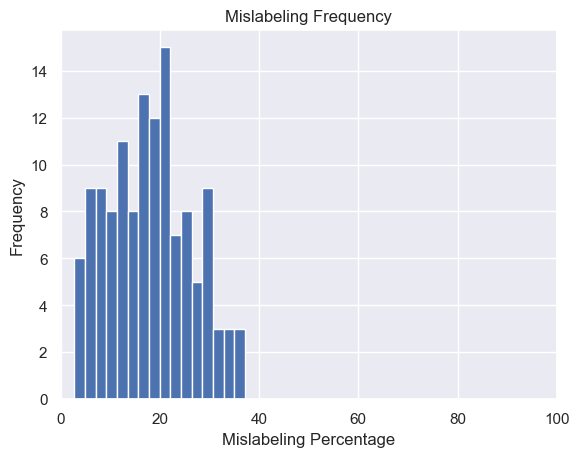

In [521]:
ax = (mislabels_by_station_rel * 100).plot.hist(bins=16, title='Mislabeling Frequency', legend=False)
ax.set_xlabel('Mislabeling Percentage')
ax.set_xlim(0, 100)

<Axes: xlabel='station'>

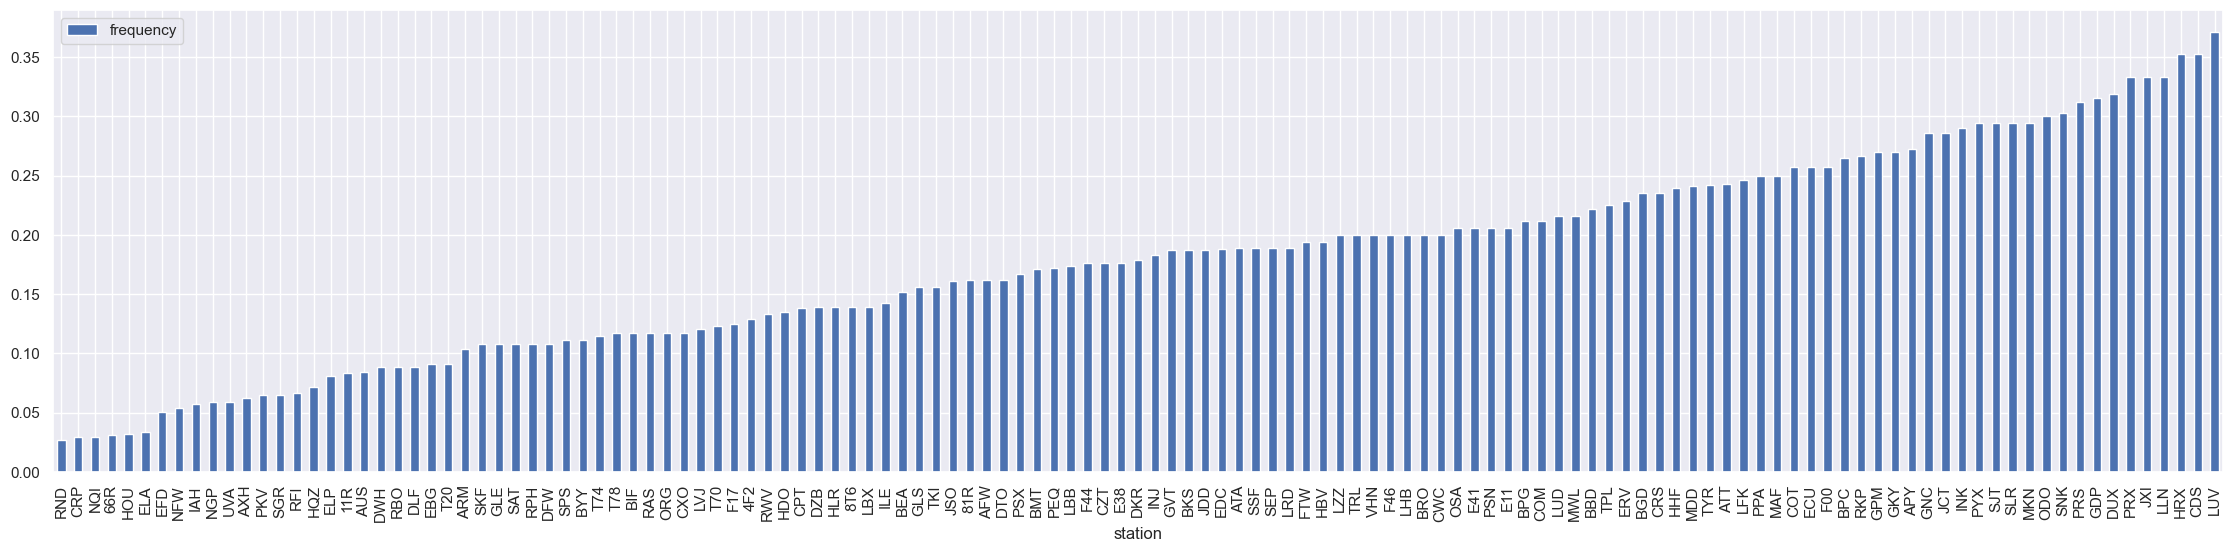

In [522]:
fig, ax = plt.subplots(figsize=(28, 6))
mislabels_by_station_rel.plot.bar(ax=ax)

In [523]:
import shapely

station_metadata = []
for state in os.listdir(os.path.join('data', 'queries')):
    station_metadata += [pd.read_csv(os.path.join('data', 'queries', state, 'preprocessing', 'station_metadata.csv'))]
station_metadata = pd.concat(station_metadata)
station_metadata['geometry'] = station_metadata['geometry'].apply(shapely.from_wkt)
station_metadata: gpd.GeoDataFrame = gpd.GeoDataFrame(station_metadata, crs='EPSG:4326')
station_metadata.set_index('id', inplace=True)
station_metadata.head()

,geometry,name,plot_name,network,latitude,longitude,elevation,index_right,ISO_A3_EH,country,CONTINENT,distance_to_region
id,,,,,,,,,,,,
AZ4299,POINT (-114.46667 32.88333),AZ4299,IMPERIAL DAM,AZCLIMATE,32.88333,-114.46667,52.1208,154,USA,United States of America,North America,0.0
AZ8678,POINT (-114.48333 34.71667),AZ8678,TOPOCK,AZCLIMATE,34.71667,-114.48333,136.8552,154,USA,United States of America,North America,0.0
AZ9662,POINT (-114.61667 32.73333),AZ9662,YUMA WB CITY,AZCLIMATE,32.73333,-114.61667,73.1520,154,USA,United States of America,North America,0.0
AAT,POINT (-120.56444 41.49139),AAT,NaN,CA_ASOS,41.49139,-120.56444,1333.0000,154,USA,United States of America,North America,0.0
ACV,POINT (-124.10861 40.97811),ACV,NaN,CA_ASOS,40.97811,-124.10861,66.0000,154,USA,United States of America,North America,0.0


In [524]:
station_metadata['mislabeled'] = np.nan

In [525]:
for station, mislabeled in mislabels_by_station_rel['frequency'].items():
    station_metadata.loc[station, 'mislabeled'] = mislabeled

In [526]:
station_metadata = gpd.GeoDataFrame(station_metadata[~station_metadata['mislabeled'].isna()])

In [527]:
usa_states = gpd.GeoDataFrame.from_file('input/us_states_5m.geojson')
usa_states.set_index('NAME', inplace=True)

(-130.0, -65.0, 22.0, 50.0)

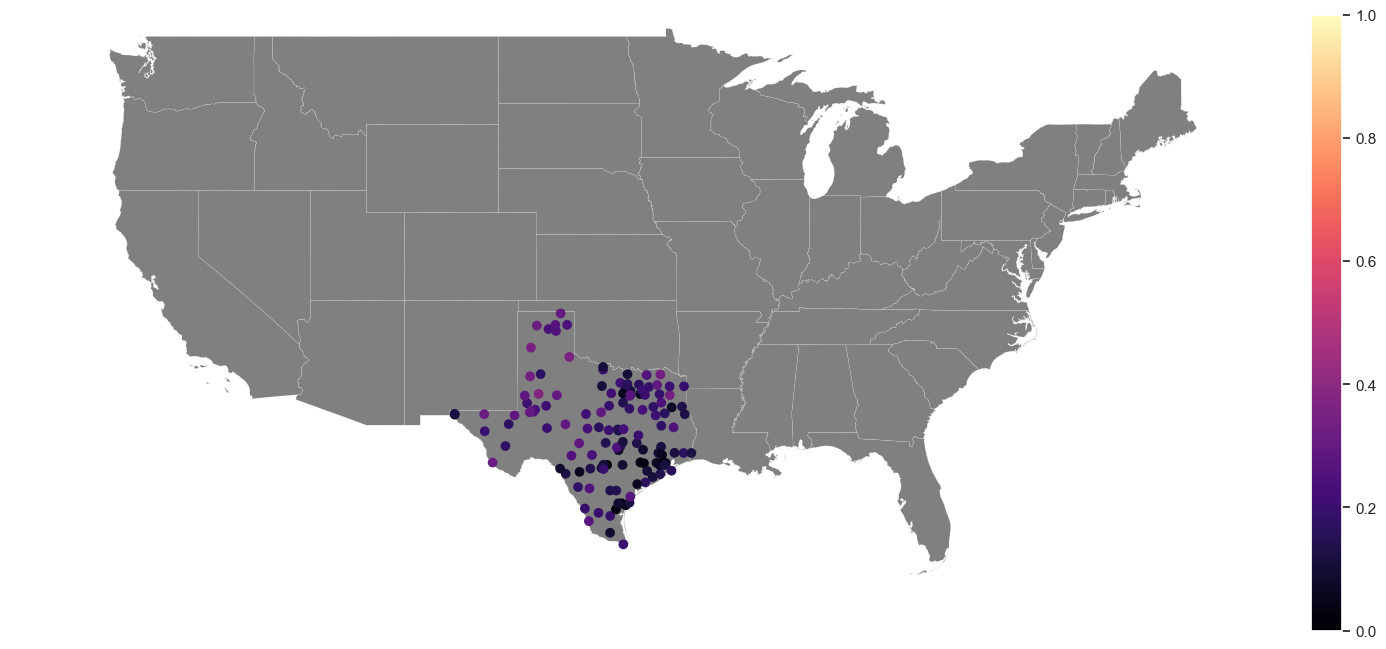

In [528]:
assert isinstance(station_metadata, gpd.GeoDataFrame)
fig, ax = plt.subplots(figsize=(20, 8))
usa_states.plot(ax=ax, facecolor='gray', linewidth=0.1)
station_metadata.plot('mislabeled', cmap='magma', vmin=0, vmax=1, ax=ax, legend=True)
ax.set_xlim(-130, -65)
ax.set_ylim(22, 50)
ax.axis(False)

In [529]:
networks = station_metadata['network'].unique()

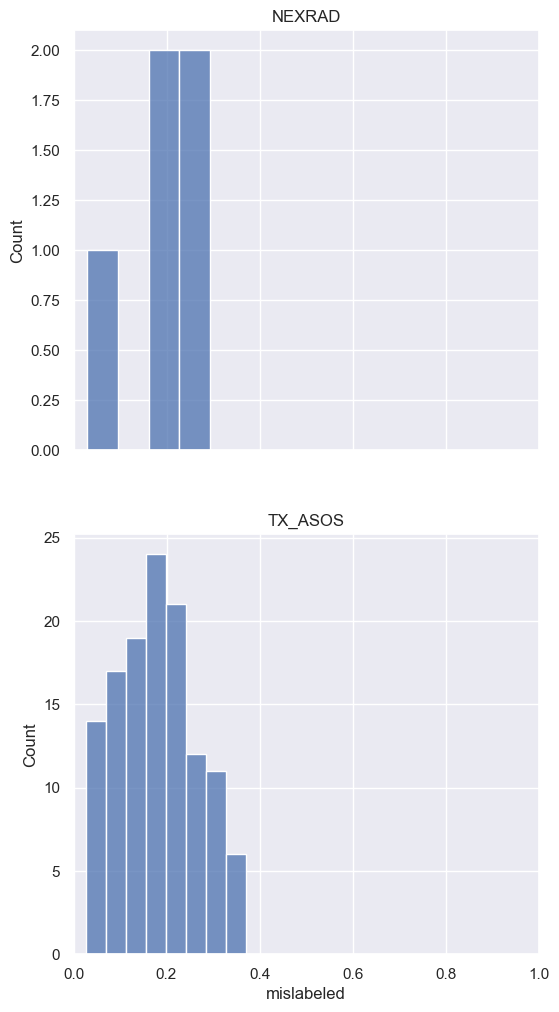

In [530]:
multi_network = len(networks) > 1
fig, axs = plt.subplots(nrows=len(networks), sharex=True, figsize=(6, 12) if multi_network else (6, 6))
for i, network in enumerate(networks):
    if multi_network:
        ax: plt.Axes = axs[i]
    else:
        ax: plt.Axes = axs
    ax.set_xlim(0, 1)
    ax.set_title(network)
    sns.histplot(station_metadata[station_metadata['network'] == network]['mislabeled'], ax=ax)

In [531]:
labels_to_analyze['true cloud cover']

0       BKN
1       BKN
2       SCT
3       CLR
4       CLR
       ... 
4843    FEW
4844    FEW
4845    BKN
4846    BKN
4847    BKN
Name: true cloud cover, Length: 4848, dtype: object